# CRM simulation with SimPy

Simulating wht a CRM system will record from a company's sales process:
- sales funnel simulation
- bidding and project implementation simulation
- reports for sales management

### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import simpy

from datetime import datetime, timedelta
from eccore.ipython import nb_setup
from eccore.core import setup_logging, logthis
from enum import Enum
from pathlib import Path
from pprint import pprint
from typing import Any, Callable, Dict, Iterable, List, Optional, Tuple
from uuid import uuid4
from functools import partial


p2log = Path('../logs/sim.log').resolve()
p2log.touch(exist_ok=True)
assert p2log.is_file()
setup_logging(logfile=p2log)
def reset_log(p2log, ):
    # with open(p2log, 'a') as f:
    with open(p2log, 'w') as f:
        f.write(f"{'='* 100}\n")
        f.write(f"New Simulation {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"{'='* 100}\n")

nb_setup()
from agents import Account, SalesRep, MarketingDpt, BaseAgent #type: ignore
from crm import CustomerRelationManagerSimulator   #type: ignore
from enums import AccountStatus, AccountType, AccountStage, Country, Industry, LeadSource # type: ignore
from enums import MktgIntents, SalesIntents, OpsIntents, Actions # type: ignore
from utils import account_info_generator, salesrep_name_generator # type: ignore

# random.seed(1988)

Logging to console and to /home/vtec/projects/diyai/crm-sim/logs/sim.log.
Logging setup finished
Added path: /home/vtec/projects/diyai/crm-sim/src
Set autoreload mode


### Simulation

In [2]:
reset_log(p2log, )
crm = CustomerRelationManagerSimulator(
    nb_salesreps=4,
    nb_mql=100,
    nb_sql=100,
    nb_others=20
)
# crm.iterate()
crm.run(until=100)

Created 100 MQL accounts
Created 100 SQL accounts
Created 20 PROSPECT accounts
Created 14 PITCHED accounts
Created 12 BIDDED accounts
Created 7 SIGNED accounts
Total accounts created: 253


In [3]:
df_stats = crm.account_stats_to_df()
nb_weeks = int((df_stats.index[-1] - df_stats.index[0]).total_seconds() /60/60/24/7)
print(f"Simulation ran for {nb_weeks:,d} weeks")

Simulation ran for 98 weeks


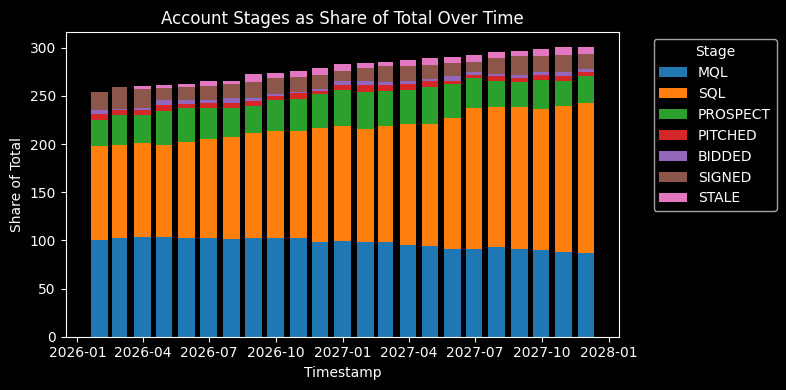

In [4]:
crm.plot_account_stats(as_share=False, hide_mql=False, hide_mql_sql=False)

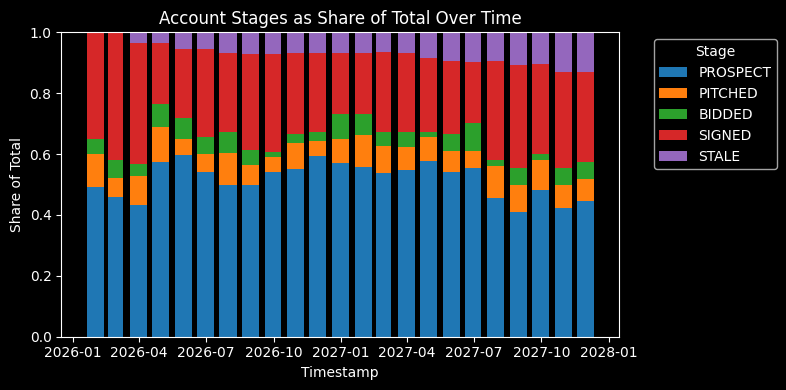

In [5]:
crm.plot_account_stats(as_share=True, hide_mql=True, hide_mql_sql=True)

In [6]:
df_stats.tail(3)

,nb_accounts,LEAD,MQL,SQL,PROSPECT,PITCHED,BIDDED,SIGNED,ACTIVE,STALE
timestamp,,,,,,,,,,
2027-11-15,301,0,87,156,29,6,2,14,0,7
2027-11-22,301,0,87,157,30,2,4,14,0,7
2027-11-29,301,0,87,156,33,4,2,12,0,7


In [7]:
ddff = crm.transactions_to_df()
ddff.intent.unique()
ddff.columns
# ddff.loc[ddff.loc[:, 'intent'] == 'opportunity', :]
# ddff.loc[ddff.loc[:, 'sender']=='acct-2a8f8ef1-1d85-4bea-9302-f300c58d4d1c'].loc[ddff.loc[:, 'value'].notna(), :]
dddfff = ddff.loc[ddff.loc[:, 'sender']=='acct-ff1da5a0-8221-4a2f-9811-ac001e8de203', :]
dddfff = ddff.loc[ddff.loc[:, 'intent'].isin(['purchase', 'opportunity']), :]
dddfff.loc[dddfff.loc[:,'value'].notna(), :].sort_values(by=['sender'])

,sender,receiver,intent,action,type,value
timestamp,,,,,,
2026-02-23,acct-01c34dea-42d2-421e-a60a-e098148ad59e,srep-60e547d2-7bd6-4565-bd02-f8b09315ed82,opportunity,opportunity forecast,external,156000.0
2026-08-17,acct-01fea1ea-f419-46c4-98fc-92142c72776c,srep-60e547d2-7bd6-4565-bd02-f8b09315ed82,opportunity,opportunity forecast,external,872000.0
2027-09-06,acct-02979092-dc61-4bc8-9cb0-122f274fc1a6,srep-60e547d2-7bd6-4565-bd02-f8b09315ed82,purchase,purchase value,external,34000.0
2027-01-25,acct-02979092-dc61-4bc8-9cb0-122f274fc1a6,srep-60e547d2-7bd6-4565-bd02-f8b09315ed82,purchase,purchase value,external,37000.0
2027-01-18,acct-02979092-dc61-4bc8-9cb0-122f274fc1a6,srep-60e547d2-7bd6-4565-bd02-f8b09315ed82,opportunity,opportunity forecast,external,37000.0
...,...,...,...,...,...,...
2027-09-20,acct-ff327cfa-a6dd-428f-b4bb-4e19e76f93fa,srep-60e547d2-7bd6-4565-bd02-f8b09315ed82,purchase,purchase value,external,153000.0
2027-03-22,acct-ff327cfa-a6dd-428f-b4bb-4e19e76f93fa,srep-60e547d2-7bd6-4565-bd02-f8b09315ed82,purchase,purchase value,external,210000.0
2027-03-15,acct-ff327cfa-a6dd-428f-b4bb-4e19e76f93fa,srep-60e547d2-7bd6-4565-bd02-f8b09315ed82,opportunity,opportunity forecast,external,210000.0


In [8]:
bizval = ddff.loc[ddff.loc[:, 'intent'].isin(['purchase', 'opportunity']), :]
opportunities = ddff.loc[ddff.loc[:, 'intent'].isin(['opportunity']), :]
purchases = ddff.loc[ddff.loc[:, 'intent'].isin(['purchase']), :]
bizval = bizval.sort_index().sort_values(by=['sender','timestamp'], ascending=True)
display(bizval.head())
display(opportunities.head())
display(purchases.head())
# bizval.loc[bizval.loc[:, 'sender']=='acct-03c631e1-3150-44b8-b97e-27aba24e9924']

,sender,receiver,intent,action,type,value
timestamp,,,,,,
2026-02-23,acct-01c34dea-42d2-421e-a60a-e098148ad59e,srep-60e547d2-7bd6-4565-bd02-f8b09315ed82,opportunity,opportunity forecast,external,156000.0
2026-08-17,acct-01fea1ea-f419-46c4-98fc-92142c72776c,srep-60e547d2-7bd6-4565-bd02-f8b09315ed82,opportunity,opportunity forecast,external,872000.0
2027-01-18,acct-02979092-dc61-4bc8-9cb0-122f274fc1a6,srep-60e547d2-7bd6-4565-bd02-f8b09315ed82,opportunity,opportunity forecast,external,37000.0
2027-01-25,acct-02979092-dc61-4bc8-9cb0-122f274fc1a6,srep-60e547d2-7bd6-4565-bd02-f8b09315ed82,purchase,purchase value,external,37000.0
2027-06-07,acct-02979092-dc61-4bc8-9cb0-122f274fc1a6,srep-60e547d2-7bd6-4565-bd02-f8b09315ed82,opportunity,opportunity forecast,external,12000.0


,sender,receiver,intent,action,type,value
timestamp,,,,,,
2026-01-05,acct-cc3fb191-f890-4a2c-8ee7-4e91037d3ea5,srep-60e547d2-7bd6-4565-bd02-f8b09315ed82,opportunity,opportunity forecast,external,452000.0
2026-01-05,acct-7961795b-0f07-4a4a-ad1f-a3abe6825b5c,srep-60e547d2-7bd6-4565-bd02-f8b09315ed82,opportunity,opportunity forecast,external,20000.0
2026-01-05,acct-8c2fbeec-b803-42e9-b4d8-5538495af69f,srep-60e547d2-7bd6-4565-bd02-f8b09315ed82,opportunity,opportunity forecast,external,10000.0
2026-01-05,acct-bc2b8d8b-e44a-4003-b23c-87fed8814ba7,srep-60e547d2-7bd6-4565-bd02-f8b09315ed82,opportunity,opportunity forecast,external,69000.0
2026-01-05,acct-2310f788-fcac-470f-a26d-cbe88b30fcd9,srep-60e547d2-7bd6-4565-bd02-f8b09315ed82,opportunity,opportunity forecast,external,668000.0


,sender,receiver,intent,action,type,value
timestamp,,,,,,
2026-01-05,acct-935fe176-3296-483c-9635-f4cf19991d19,srep-60e547d2-7bd6-4565-bd02-f8b09315ed82,purchase,purchase value,external,0.0
2026-01-05,acct-aa79ff4c-ebe2-49a4-80bb-da80639f6cba,srep-60e547d2-7bd6-4565-bd02-f8b09315ed82,purchase,purchase value,external,0.0
2026-01-05,acct-49a7a377-a5bc-4cd7-8382-c0b63e0e19f7,srep-60e547d2-7bd6-4565-bd02-f8b09315ed82,purchase,purchase value,external,0.0
2026-01-05,acct-5d9db7d8-a0bf-4a54-a7aa-23d93be2c7c9,srep-60e547d2-7bd6-4565-bd02-f8b09315ed82,purchase,purchase value,external,0.0
2026-01-05,acct-c2572439-7e11-4226-a108-a8a05e9a7340,srep-60e547d2-7bd6-4565-bd02-f8b09315ed82,purchase,purchase value,external,0.0


In [9]:
opps_per_account = opportunities.groupby(by=['sender']).agg({ 'receiver':'last','intent': 'count', 'action': 'last', 'value':'sum'})
opps_per_account

,receiver,intent,action,value
sender,,,,
acct-01c34dea-42d2-421e-a60a-e098148ad59e,srep-60e547d2-7bd6-4565-bd02-f8b09315ed82,1,opportunity forecast,156000.0
acct-01fea1ea-f419-46c4-98fc-92142c72776c,srep-60e547d2-7bd6-4565-bd02-f8b09315ed82,1,opportunity forecast,872000.0
acct-02979092-dc61-4bc8-9cb0-122f274fc1a6,srep-60e547d2-7bd6-4565-bd02-f8b09315ed82,3,opportunity forecast,83000.0
acct-036cce85-548d-44ea-b925-4a8fed267cf9,srep-60e547d2-7bd6-4565-bd02-f8b09315ed82,2,opportunity forecast,29000.0
acct-049bf53e-a802-4d32-9ef4-59a3d87a3fad,srep-60e547d2-7bd6-4565-bd02-f8b09315ed82,3,opportunity forecast,110000.0
...,...,...,...,...
acct-f3246fe6-e4b5-4a59-ac1f-1723cb9e849c,srep-60e547d2-7bd6-4565-bd02-f8b09315ed82,1,opportunity forecast,11000.0
acct-f6a8635b-1321-4ed4-818b-597524f52403,srep-60e547d2-7bd6-4565-bd02-f8b09315ed82,2,opportunity forecast,390000.0
acct-f7a06122-e9ec-4739-871f-8b8006cf4a3d,srep-60e547d2-7bd6-4565-bd02-f8b09315ed82,1,opportunity forecast,589000.0


In [10]:
pos_per_account = purchases.groupby(by=['sender']).agg({ 'receiver':'last','intent': 'count', 'action': 'last', 'value':'sum'})
pos_per_account

,receiver,intent,action,value
sender,,,,
acct-02979092-dc61-4bc8-9cb0-122f274fc1a6,srep-60e547d2-7bd6-4565-bd02-f8b09315ed82,2,purchase value,71000.0
acct-049bf53e-a802-4d32-9ef4-59a3d87a3fad,srep-60e547d2-7bd6-4565-bd02-f8b09315ed82,2,purchase value,77000.0
acct-0af0ad4b-f257-4e56-8ee1-e2932a835400,srep-60e547d2-7bd6-4565-bd02-f8b09315ed82,3,purchase value,389000.0
acct-0db1c0e9-075e-4488-b7c9-f1b4b619ae31,srep-60e547d2-7bd6-4565-bd02-f8b09315ed82,1,purchase value,629000.0
acct-0e4ce332-0569-4865-86c9-a73fd5cb1f06,srep-60e547d2-7bd6-4565-bd02-f8b09315ed82,2,purchase value,165000.0
...,...,...,...,...
acct-eb584a91-d6f5-4cce-a9f3-1841a61429b1,srep-60e547d2-7bd6-4565-bd02-f8b09315ed82,1,purchase value,34000.0
acct-edf20298-f5b0-4a92-b906-41608171fc48,srep-60e547d2-7bd6-4565-bd02-f8b09315ed82,1,purchase value,124000.0
acct-f3246fe6-e4b5-4a59-ac1f-1723cb9e849c,srep-60e547d2-7bd6-4565-bd02-f8b09315ed82,1,purchase value,11000.0


In [11]:
business_per_account = pd.merge(left=opps_per_account.loc[:, ['intent', 'value']], right=pos_per_account.loc[:, ['intent', 'value']], how='left', left_index=True, right_index=True, suffixes=('_opp', '_po'))
business_per_account = pd.merge(left=business_per_account, right=crm.account_df().loc[:, ['name', 'account_type','industry', 'country', 'cumulative_opportunity_value', 'cumulative_purchase_value', 'nb_opportunities', 'nb_purchases', 'uid']], how='left', left_index=True, right_on='uid')
business_per_account.columns = '|'.join(business_per_account.columns).replace('intent_', 'nb_').split('|')
business_per_account['avg_opp'] = business_per_account['value_opp'] / business_per_account['nb_opp']
business_per_account['avg_po'] = business_per_account['value_po'].div(business_per_account['nb_po'])
business_per_account['success_rate_value'] = business_per_account['value_po']/business_per_account['value_opp']
business_per_account['success_rate_nb'] = business_per_account['nb_po']/business_per_account['nb_opp']
business_per_account = business_per_account.fillna(0)
business_per_account.head()

,nb_opp,value_opp,nb_po,value_po,name,account_type,industry,country,cumulative_opportunity_value,cumulative_purchase_value,nb_opportunities,nb_purchases,uid,avg_opp,avg_po,success_rate_value,success_rate_nb
222,1,156000.0,0.0,0.0,RoscommonFlex Ltd.,MEDIUM,Electronics,EU,156000,0,1,0,acct-01c34dea-42d2-421e-a60a-e098148ad59e,156000.000000,0.0,0.000000,0.000000
241,1,872000.0,0.0,0.0,OstravaPack s.r.o.,LARGE,AutomotiveParts,EU,872000,0,1,0,acct-01fea1ea-f419-46c4-98fc-92142c72776c,872000.000000,0.0,0.000000,0.000000
133,3,83000.0,2.0,71000.0,FrankfurtPack AG,SMALL,Pharmaceuticals,EU,83000,71000,3,0,acct-02979092-dc61-4bc8-9cb0-122f274fc1a6,27666.666667,35500.0,0.855422,0.666667
119,2,29000.0,0.0,0.0,EliteWrap Corp.,SMALL,IndustrialManufacturing,US,29000,0,2,0,acct-036cce85-548d-44ea-b925-4a8fed267cf9,14500.000000,0.0,0.000000,0.000000
191,3,110000.0,2.0,77000.0,TopPack Ltd.,SMALL,FoodnBeverage,CN,110000,77000,3,0,acct-049bf53e-a802-4d32-9ef4-59a3d87a3fad,36666.666667,38500.0,0.700000,0.666667


In [12]:
business_per_account.groupby(by='account_type').agg({'success_rate_value':'mean','success_rate_nb':'mean','avg_opp':'mean','avg_po':'mean','value_opp':'sum','value_po':'sum','nb_opp':'sum','nb_po':'sum'})

,success_rate_value,success_rate_nb,avg_opp,avg_po,value_opp,value_po,nb_opp,nb_po
account_type,,,,,,,,
LARGE,0.482411,0.500000,646035.714286,374377.976190,63326000.0,32483000.0,99,53.0
MEDIUM,0.481674,0.498188,152246.376812,90431.159420,12879000.0,6820000.0,86,48.0
SMALL,0.480415,0.514423,29131.410256,18217.948718,2985000.0,1489000.0,103,55.0


In [13]:
business_per_account.groupby(by='industry').agg({'success_rate_value':'mean','success_rate_nb':'mean','avg_opp':'mean','avg_po':'mean','value_opp':'sum','value_po':'sum','nb_opp':'sum','nb_po':'sum'})

,success_rate_value,success_rate_nb,avg_opp,avg_po,value_opp,value_po,nb_opp,nb_po
industry,,,,,,,,
AutomotiveParts,0.563810,0.566667,156100.000000,64550.000000,2116000.0,827000.0,15,8.0
Chemicals,0.449037,0.464912,264000.000000,151377.192982,12424000.0,4411000.0,44,21.0
ConsumerGoods,0.362678,0.393939,351000.000000,169431.818182,12340000.0,5231000.0,38,18.0
Electronics,0.485020,0.488095,371146.825397,245992.063492,14490000.0,8850000.0,39,22.0
FoodnBeverage,0.447656,0.466667,222787.500000,62208.333333,5998000.0,1771000.0,39,21.0
IndustrialManufacturing,0.497410,0.537500,278387.500000,201458.333333,11216000.0,6936000.0,41,24.0
PackagingSI,0.554291,0.631579,273855.263158,154833.333333,9221000.0,4005000.0,31,19.0
Pharmaceuticals,0.538548,0.528986,320710.144928,236615.942029,11385000.0,8761000.0,41,23.0


In [14]:
business_per_account.groupby(by='country').agg({'success_rate_value':'mean','success_rate_nb':'mean','avg_opp':'mean','avg_po':'mean','value_opp':'sum','value_po':'sum','nb_opp':'sum','nb_po':'sum'})

,success_rate_value,success_rate_nb,avg_opp,avg_po,value_opp,value_po,nb_opp,nb_po
country,,,,,,,,
CN,0.508920,0.525510,315600.340136,189581.632653,25733000.0,14011000.0,88,51.0
EU,0.483879,0.516432,288772.300469,172107.981221,36368000.0,17464000.0,134,71.0
US,0.437090,0.448529,256732.843137,134210.784314,17089000.0,9317000.0,66,34.0


### Funnel Analysis

In [15]:
df = crm.transactions_to_df()
df.loc[df.action == 'transition',:].intent.unique()

array(['SQL to PROSPECT', 'PITCHED to BIDDED', 'PITCHED to SQL',
       'BIDDED to SIGNED', 'BIDDED to SQL', 'SQL to SQL',
       'PROSPECT to SQL', 'PROSPECT to PITCHED', 'MQL to SQL',
       'SIGNED to PROSPECT', 'SIGNED to STALE'], dtype=object)

In [16]:
coi = [
    # 'MQL to SQL',
    'SQL to PROSPECT', 
    'SQL to SQL', 
    'PROSPECT to PITCHED', 
    'PROSPECT to SQL', 
    'PITCHED to BIDDED', 
    'PITCHED to SQL',
    'BIDDED to SIGNED',
    'BIDDED to SQL',
    'SIGNED to PROSPECT', 
    'SIGNED to STALE'
       ]
coi_success = [
    # 'MQL to SQL',
    'SQL to PROSPECT', 
    'PROSPECT to PITCHED', 
    'PITCHED to BIDDED', 
    'BIDDED to SIGNED',
    'SIGNED to PROSPECT', 
       ]
coi_fail = [
    # 'MQL to SQL',
    'SQL to SQL', 
    'PROSPECT to SQL', 
    'PITCHED to SQL',
    'BIDDED to SQL',
    'SIGNED to STALE'
       ]
funnel_trans = df.loc[df.action == 'transition',:]

In [17]:
funnel_trans.groupby('intent').count()

,sender,receiver,action,type,value
intent,,,,,
BIDDED to SIGNED,322,322,322,322,0
BIDDED to SQL,270,270,270,270,0
MQL to SQL,63,63,63,63,0
PITCHED to BIDDED,576,576,576,576,0
PITCHED to SQL,362,362,362,362,0
PROSPECT to PITCHED,922,922,922,922,0
PROSPECT to SQL,638,638,638,638,0
SIGNED to PROSPECT,294,294,294,294,0
SIGNED to STALE,14,14,14,14,0


In [114]:
cois = {
    # 'MQL to SQL': 'MQL',
    'SQL to PROSPECT': 'SQL',
    'PROSPECT to PITCHED': 'PROSPECT',
    'PITCHED to BIDDED': 'PITCHED',
    'BIDDED to SIGNED': 'BIDDED',
    'SIGNED to PROSPECT': 'SIGNED',
}

list(map(lambda x: cois[x], ['SQL to PROSPECT', 'PROSPECT to PITCHED', 'PITCHED to BIDDED', 'BIDDED to SIGNED', 'SIGNED to PROSPECT']))

['SQL', 'PROSPECT', 'PITCHED', 'BIDDED', 'SIGNED']

In [171]:
def build_funnel(df):
    coi_success = {
        # 'MQL to SQL': 'MQL',
        'SQL to PROSPECT': 'SQL',
        'PROSPECT to PITCHED': 'PROSPECT',
        'PITCHED to BIDDED': 'PITCHED',
        'BIDDED to SIGNED': 'BIDDED',
        'SIGNED to PROSPECT': 'SIGNED',
    }
    coi_fail = {
        # 'MQL to SQL': 'MQL,
        'SQL to SQL': 'SQL',
        'PROSPECT to SQL': 'PROSPECT',
        'PITCHED to SQL': 'PITCHED',
        'BIDDED to SQL': 'BIDDED',
        'SIGNED to STALE': 'SIGNED',
    }
    def _funnel(df, cois, coif, aggfn:str):
        t_success = df.groupby(by='intent').agg(aggfn).T
        cols = [k for k, v in cois.items() if k in t_success.columns]
        t_success = t_success.loc[['action'],cols]
        cols = list(map(lambda x: cois[x], list(t_success.columns)))
        t_success.columns = cols
        t_fail = df.groupby(by='intent').agg(aggfn).T
        cols = [k for k, v in coif.items() if k in t_fail.columns]
        t_fail = t_fail.loc[['action'],cols]
        cols = list(map(lambda x: coif[x], list(t_fail.columns)))
        t_fail.columns = cols
        funnel = pd.concat([t_success, t_fail], axis=0)
        funnel.index = ['success', 'failed'] #type: ignore
        funnel.loc['total', :] = funnel.sum()
        return funnel
    
    funnels = {}
    if isinstance(df.index, pd.MultiIndex):
        for idx in list(set([idx[0] for idx in df.index])):
            funnels[idx] = _funnel(df.loc[(idx,),:], coi_success, coi_fail, 'sum')
    else:
        funnels['all'] = _funnel(df, coi_success, coi_fail, 'sum')
    return funnels

In [173]:
funnel_dict = build_funnel(funnel_trans.groupby('intent').count())
funnel_dict['all']

,SQL,PROSPECT,PITCHED,BIDDED,SIGNED
success,1292.0,922.0,576.0,322.0,294.0
failed,308.0,638.0,362.0,270.0,14.0
total,1600.0,1560.0,938.0,592.0,308.0


In [174]:
def plot_funnel(funnel, title=None, figsize=(8, 3)):
    # reversed_cols = funnel.columns[::-1]
    fig,ax = plt.subplots(figsize=figsize)
    df = funnel.loc['total', :] / funnel.loc['total','SQL']
    bars = df.T.plot(kind='barh', ax=ax, title=title or 'Conversion Rates')
    ax.invert_yaxis()
    # Add value labels to each bar
    max_val = df.max()
    ax.set_xlim(0, max_val * 1.15)  # Add 15% padding to the right
    for i, v in enumerate(df.values):
        ax.text(v + 0.01, i, f"{v:.2f}", va='center', ha='left',fontsize=10)
    plt.show()

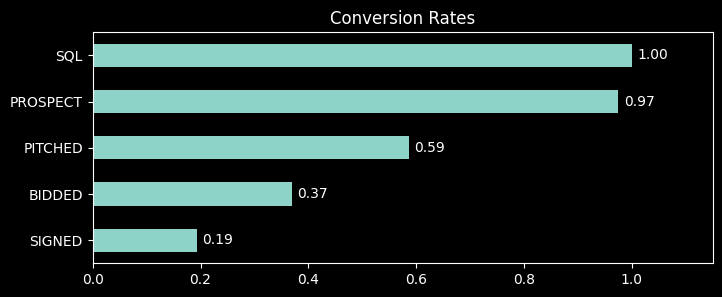

In [175]:
plot_funnel(funnel_dict['all'])

In [176]:
wkly_avg = funnel_dict['all'] / nb_weeks
print('Weekly Average:')
wkly_avg

Weekly Average:


,SQL,PROSPECT,PITCHED,BIDDED,SIGNED
success,13.183673,9.408163,5.877551,3.285714,3.000000
failed,3.142857,6.510204,3.693878,2.755102,0.142857
total,16.326531,15.918367,9.571429,6.040816,3.142857


### Build Detailed Dataset

In [177]:
funnel_uid = funnel_trans.receiver.unique()
print(len(funnel_uid), 'accounts in the funnel')
print(' | '.join(funnel_uid[:3]))
funnel_trans.tail(3)

216 accounts in the funnel
acct-9f097a6c-7967-4b79-aab9-e4e9324527ae | acct-36a7313e-d15e-498e-926e-0ffce16d3b6e | acct-4d30065e-c970-4f05-9d6b-00599b523243


,sender,receiver,intent,action,type,value
timestamp,,,,,,
2027-12-01 02:24:00,srep-60e547d2-7bd6-4565-bd02-f8b09315ed82,acct-cb0ac5c7-c6aa-43f3-8d3c-485a9ea9f39d,SQL to PROSPECT,transition,internal,NaN
2027-12-05 07:12:00,crm-557a5dc5-1d8d-4317-84cc-f78ec8f76c70,acct-b635b36b-729f-48e3-95a5-6d5e3367bf6d,MQL to SQL,transition,system,NaN
2027-12-05 07:12:00,crm-557a5dc5-1d8d-4317-84cc-f78ec8f76c70,acct-f690da03-a2ff-42a3-8764-d9abcd3d52da,MQL to SQL,transition,system,NaN


In [178]:
acct_ds = crm.account_df()
acct_uid = acct_ds['uid'].unique()
print(len(acct_uid), 'accounts in the crm record')
print((' | '.join(acct_uid[:3])))
acct_ds.tail(3)

301 accounts in the crm record
acct-2f6700ee-8203-44ca-b788-a53a183f24a2 | acct-13141fd2-a2aa-4b12-b407-e0b8326d19a9 | acct-f6a8635b-1321-4ed4-818b-597524f52403


,account_type,assigned_salesrep,country,cumulative_opportunity_value,cumulative_purchase_value,industry,lead_source,name,nb_opportunities,nb_purchases,stage,uid
298,MEDIUM,srep-60e547d2-7bd6-4565-bd02-f8b09315ed82,CN,0,0,ConsumerGoods,SALES_REP,"HoChiMinhPack Co., Ltd.",0,0,MQL,acct-752203bf-87c4-4611-857b-f4b6e5eff5e4
299,SMALL,srep-60e547d2-7bd6-4565-bd02-f8b09315ed82,US,0,0,ConsumerGoods,EMAIL_CAMPAIGN,PrimeWrap Corp.,0,0,MQL,acct-fb5ef465-8146-4660-92f0-de794ee21b50
300,MEDIUM,srep-60e547d2-7bd6-4565-bd02-f8b09315ed82,US,0,0,PackagingSI,INDUSTRY_EVENT,AnchorPac Corp.,0,0,MQL,acct-391d7c9d-0852-4b01-bc2a-76c675d7edfa


In [179]:
srep_ds = crm.salesrep_df()
srep_uid = srep_ds.uid.unique()
print(len(srep_ds), 'sales reps in the crm record')
print((' | '.join(srep_uid[:3])))
srep_ds.tail(3)

4 sales reps in the crm record
srep-60e547d2-7bd6-4565-bd02-f8b09315ed82 | srep-adef7be4-dc25-48a9-8e82-82d0f82bd0ad | srep-f5782781-6fca-433b-80de-2bee7b9d069f


,name,uid
1,SalesRep 2,srep-adef7be4-dc25-48a9-8e82-82d0f82bd0ad
2,SalesRep 3,srep-f5782781-6fca-433b-80de-2bee7b9d069f
3,SalesRep 4,srep-dc98a705-f888-436f-9002-91bb56a0a751


In [180]:
print(f"{len(set(acct_uid).intersection(set(funnel_uid))):,d} accounts in the funnel")
# print(f"{len(set(srep_uid).intersection(set(funnel_uid))):,d} accounts in the funnel")

216 accounts in the funnel


In [181]:
funnel_ds = pd.merge(left=funnel_trans, right=acct_ds, how='left', left_on='receiver', right_on='uid')
print(funnel_ds.shape)
print(funnel_ds.uid.unique().shape)
funnel_ds.head(3)

(5061, 18)
(216,)


,sender,receiver,intent,action,type,value,account_type,assigned_salesrep,country,cumulative_opportunity_value,cumulative_purchase_value,industry,lead_source,name,nb_opportunities,nb_purchases,stage,uid
0,crm-557a5dc5-1d8d-4317-84cc-f78ec8f76c70,acct-9f097a6c-7967-4b79-aab9-e4e9324527ae,SQL to PROSPECT,transition,system,NaN,MEDIUM,srep-60e547d2-7bd6-4565-bd02-f8b09315ed82,EU,459000,222000,ConsumerGoods,EMAIL_CAMPAIGN,BonnFlex GmbH,3,0,PROSPECT,acct-9f097a6c-7967-4b79-aab9-e4e9324527ae
1,srep-adef7be4-dc25-48a9-8e82-82d0f82bd0ad,acct-9f097a6c-7967-4b79-aab9-e4e9324527ae,SQL to PROSPECT,transition,internal,NaN,MEDIUM,srep-60e547d2-7bd6-4565-bd02-f8b09315ed82,EU,459000,222000,ConsumerGoods,EMAIL_CAMPAIGN,BonnFlex GmbH,3,0,PROSPECT,acct-9f097a6c-7967-4b79-aab9-e4e9324527ae
2,crm-557a5dc5-1d8d-4317-84cc-f78ec8f76c70,acct-36a7313e-d15e-498e-926e-0ffce16d3b6e,SQL to PROSPECT,transition,system,NaN,SMALL,srep-60e547d2-7bd6-4565-bd02-f8b09315ed82,US,24000,0,IndustrialManufacturing,EXISTING_CUSTOMER,OhioFlex LLC,1,0,SQL,acct-36a7313e-d15e-498e-926e-0ffce16d3b6e


In [182]:
funnel_per_type = funnel_ds.groupby(by=['account_type', 'intent']).count().loc[:, ['action']]
funnel_per_type

action
account_type intent                     
LARGE        BIDDED to SIGNED        110
             BIDDED to SQL            96
             MQL to SQL               18
             PITCHED to BIDDED       198
             PITCHED to SQL          124
             PROSPECT to PITCHED     316
             PROSPECT to SQL         228
             SIGNED to PROSPECT      100
             SIGNED to STALE           8
             SQL to PROSPECT         460
             SQL to SQL              106
MEDIUM       BIDDED to SIGNED         98
             BIDDED to SQL            76
             MQL to SQL               24
             PITCHED to BIDDED       172
             PITCHED to SQL          118
             PROSPECT to PITCHED     288
             PROSPECT to SQL         200
             SIGNED to PROSPECT       86
             SIGNED to STALE           4
             SQL to PROSPECT         402
             SQL to SQL              102
SMALL        BIDDED to SIGNED        114
             BIDDED to SQL            98
             MQL to SQL               21
             PITCHED to BIDDED       206
             PITCHED to SQL          120
             PROSPECT to PITCHED     318
             PROSPECT to SQL         210
             SIGNED to PROSPECT      108
             SIGNED to STALE           2
             SQL to PROSPECT         430
             SQL to SQL              100

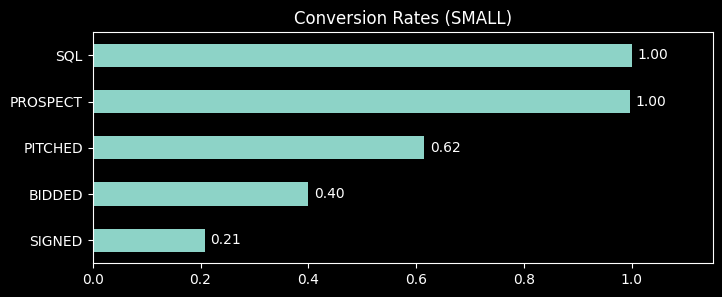

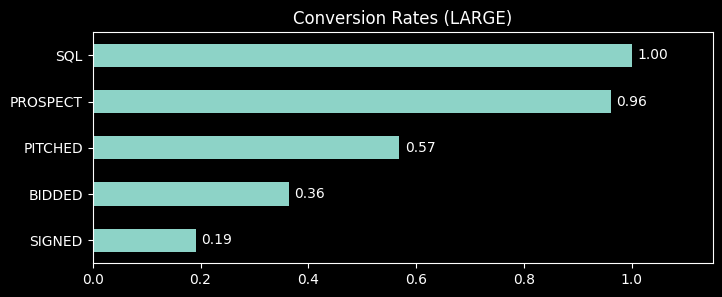

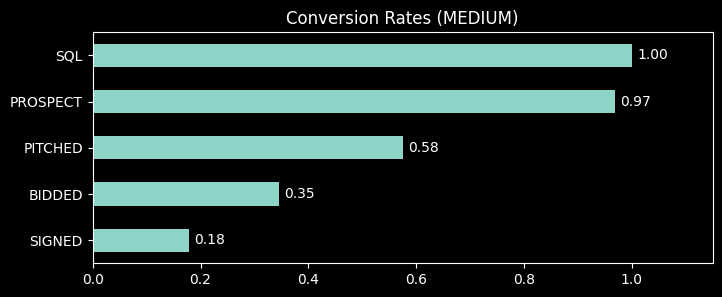

In [183]:
funnel_dict_per_type = build_funnel(funnel_per_type)
for k,v in funnel_dict_per_type.items():
    plot_funnel(v, title=f"Conversion Rates ({k})",figsize=(8, 3))

In [184]:
funnel_ds.head(3)

,sender,receiver,intent,action,type,value,account_type,assigned_salesrep,country,cumulative_opportunity_value,cumulative_purchase_value,industry,lead_source,name,nb_opportunities,nb_purchases,stage,uid
0,crm-557a5dc5-1d8d-4317-84cc-f78ec8f76c70,acct-9f097a6c-7967-4b79-aab9-e4e9324527ae,SQL to PROSPECT,transition,system,NaN,MEDIUM,srep-60e547d2-7bd6-4565-bd02-f8b09315ed82,EU,459000,222000,ConsumerGoods,EMAIL_CAMPAIGN,BonnFlex GmbH,3,0,PROSPECT,acct-9f097a6c-7967-4b79-aab9-e4e9324527ae
1,srep-adef7be4-dc25-48a9-8e82-82d0f82bd0ad,acct-9f097a6c-7967-4b79-aab9-e4e9324527ae,SQL to PROSPECT,transition,internal,NaN,MEDIUM,srep-60e547d2-7bd6-4565-bd02-f8b09315ed82,EU,459000,222000,ConsumerGoods,EMAIL_CAMPAIGN,BonnFlex GmbH,3,0,PROSPECT,acct-9f097a6c-7967-4b79-aab9-e4e9324527ae
2,crm-557a5dc5-1d8d-4317-84cc-f78ec8f76c70,acct-36a7313e-d15e-498e-926e-0ffce16d3b6e,SQL to PROSPECT,transition,system,NaN,SMALL,srep-60e547d2-7bd6-4565-bd02-f8b09315ed82,US,24000,0,IndustrialManufacturing,EXISTING_CUSTOMER,OhioFlex LLC,1,0,SQL,acct-36a7313e-d15e-498e-926e-0ffce16d3b6e


In [185]:
funnel_per_country = funnel_ds.groupby(by=['country', 'intent']).count().loc[:, ['action']]
funnel_per_country

action
country intent                     
CN      BIDDED to SIGNED        108
        BIDDED to SQL            76
        MQL to SQL               19
        PITCHED to BIDDED       176
        PITCHED to SQL          132
        PROSPECT to PITCHED     300
        PROSPECT to SQL         238
        SIGNED to PROSPECT       94
        SIGNED to STALE           8
        SQL to PROSPECT         452
        SQL to SQL              106
EU      BIDDED to SIGNED        146
        BIDDED to SQL           130
        MQL to SQL               26
        PITCHED to BIDDED       268
        PITCHED to SQL          136
        PROSPECT to PITCHED     392
        PROSPECT to SQL         298
        SIGNED to PROSPECT      140
        SIGNED to STALE           6
        SQL to PROSPECT         564
        SQL to SQL              136
US      BIDDED to SIGNED         68
        BIDDED to SQL            64
        MQL to SQL               18
        PITCHED to BIDDED       132
        PITCHED to SQL           94
        PROSPECT to PITCHED     230
        PROSPECT to SQL         102
        SIGNED to PROSPECT       60
        SQL to PROSPECT         276
        SQL to SQL               66

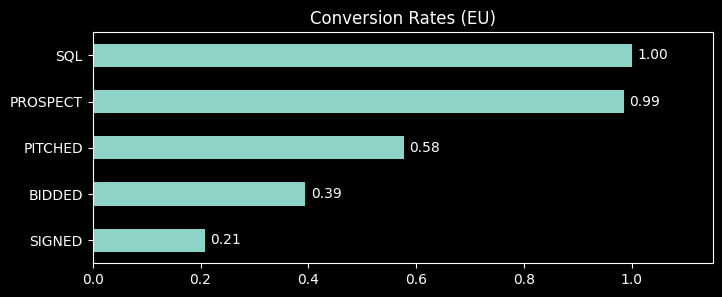

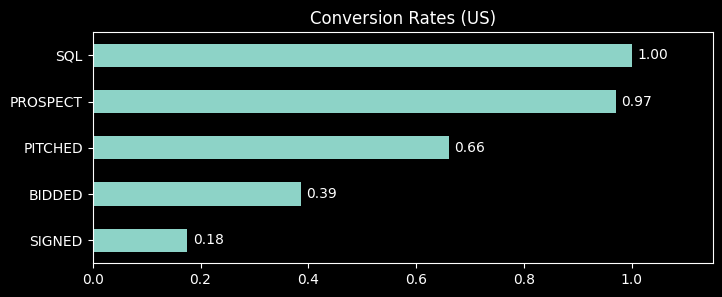

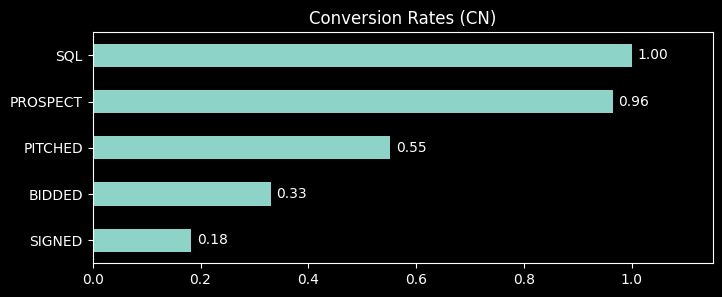

In [186]:
funnel_dict_per_type = build_funnel(funnel_per_country)
for k,v in funnel_dict_per_type.items():
    plot_funnel(v, title=f"Conversion Rates ({k})",figsize=(8, 3))

#### Reference Conversion Rates

##### MQL
- website
    - nb mthly website visitor=2900 monthly
    - website cta rate=0.03
- email
    - online campaigns targets=1000 monthly
    - online campaigns clickthru=0.1
- industry event
    - nb industry events=1 quarterly
    - rawleads industry events=80 * nb industry events
- direct calls
    - rawleads salesreps=30 monthly (?)
- conversion 
    - rawlead2mql website=0.41
    - rawlead2mql online campaign=0.38
    - rawlead2mql industry event=0.3
    - salesrep leads2mql=0.02

##### SQL and later stages
- conversion
    - mql2sql=0.15
    - sql2prospect=0.7
    - prospect2prez=0.7
    - prez2bid=0.6
    - bid2close=0.3
    - customer satisfaction rate=0.98

- delays
    - mql2sql= 1 to 2 weeks
    - sql2prospect= 1 to 2 weeks
    - prospect2prez= 1 to 4 weeks
    - prez2bid= 2 to 12 weeks
    - bid2close= 2 to 12 weeks
    - customer project duration = 12 to 24 weeks


- decay rate=0.15

In [ ]:
crm = CustomerRelationManagerSimulator(nb_salesreps=3, nb_mql=10, nb_sql=0, nb_others=0)
with open(p2log, 'w') as f:
    f.write(f"CRM simulation started at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"CRM UID: {crm.uid}\n")
    f.write(f"CRM Name: {crm.name}\n")
    f.write(f"{'='* 100}")

crm.run(until=100)

marketing registered process: send_email_campaign with kwargs: {}
salesrep registered process: request_user_need_discovery with kwargs: None
salesrep registered process: request_user_need_discovery with kwargs: None
salesrep registered process: request_user_need_discovery with kwargs: None
Created 10 MQL accounts
Total accounts created: 10


In [30]:
df = crm.transactions_to_df()
df.loc[df.type != 'system', :]
df.loc[df.action == 'accept', :]
df.tail()

,sender,reviever,intent,action,type
timestamp,,,,,
2027-11-29,srep-4a8ed8cc-92c1-420c-827f-65544794b2ef,acct-d87b130d-e72e-4c95-82b3-768fa2fcb81f,user need discovery,request,External
2027-11-29,srep-6a551d17-f9d5-4a26-a902-db4f9f6aae50,acct-d87b130d-e72e-4c95-82b3-768fa2fcb81f,user need discovery,request,External
2027-11-29,srep-322ca857-115e-482e-a46d-47954ef9e4b9,acct-f36ccb19-4d9c-4f81-9061-25b8803ad3f1,user need discovery,request,External
2027-11-29,srep-4a8ed8cc-92c1-420c-827f-65544794b2ef,acct-2e1eb3c3-788e-4776-850c-b959edbf915c,user need discovery,request,External
2027-11-29,srep-6a551d17-f9d5-4a26-a902-db4f9f6aae50,acct-f36ccb19-4d9c-4f81-9061-25b8803ad3f1,user need discovery,request,External


In [ ]:
crm.account_stats_to_df(int_idx=True)

,timestamp,nb_accounts,LEAD,MQL,SQL,PROSPECT,PITCHED,BIDDED,SIGNED,ACTIVE,STALE
0,1,10,0,4,6,0,0,0,0,0,0
1,2,10,0,4,6,0,0,0,0,0,0
2,3,10,0,4,6,0,0,0,0,0,0
3,4,10,0,2,8,0,0,0,0,0,0
4,5,10,0,2,8,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
94,95,10,0,0,10,0,0,0,0,0,0
95,96,10,0,0,10,0,0,0,0,0,0
96,97,10,0,0,10,0,0,0,0,0,0
97,98,10,0,0,10,0,0,0,0,0,0


# Sandbox

### Check the countries represented in the data

In [33]:
p2data = Path('../data/account-info-clean.tsv').resolve()
assert p2data.is_file(), p2data

In [40]:
df = pd.read_csv(p2data, sep='\t')
display(df.head())
df.Country = df.Country.str.split('.').apply(lambda x: x[1].strip())
df.head()

,Country,Company Name,Industry
0,Country.EU,EuroPac GmbH,FoodnBeverage
1,Country.EU,Alpine Packaging S.A.,ConsumerGoods
2,Country.EU,PackItalia S.p.A.,Pharmaceuticals
3,Country.EU,DutchFlex BV,IndustrialManufacturing
4,Country.EU,Belgipack NV,Chemicals


,Country,Company Name,Industry
0,EU,EuroPac GmbH,FoodnBeverage
1,EU,Alpine Packaging S.A.,ConsumerGoods
2,EU,PackItalia S.p.A.,Pharmaceuticals
3,EU,DutchFlex BV,IndustrialManufacturing
4,EU,Belgipack NV,Chemicals


In [41]:
df.to_csv(p2data, sep='\t', index=False)

In [34]:
pd.read_csv(p2data, sep='\t').Country.str.split('.').apply(lambda x: x[1]).unique()

array(['EU', 'CN', 'US'], dtype=object)

In [322]:
from utils import account_info_generator

In [323]:
cgen = account_info_generator()

In [329]:
next(cgen)  # skip first

Country                    Country.US
Company Name    RiverPac Systems Inc.
Industry                  Electronics
Name: 5, dtype: object